# CNN Model

For the construction of the first model, the process began by applying a simple convolutional neural network with three convolutional layers. Each of these layers is followed by a ReLU activation layer and a MaxPooling layer, which will group information from the nearest neighbors within the feature map. This way, a set with the most important features identified by the convolution filter is obtained, with the advantage of further reducing the volume of information. The output is flattened and passed as inputs to linear layers responsible for adjusting the weights of the neurons until providing the correct classification for the observation.

### Loading and preparation of the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import check_device, make_dataset
from models import cnn_model as cnn
from visualization import visualize

torch.manual_seed(1006)
np.random.seed(1006)

In [2]:
device = check_device.set_device()
print(device)

cuda


In [3]:
path_dir = "../../kaggle/pneumoniaDataset/chest_xray"

train_data_dir, test_data_dir = make_dataset.path_dataset(path_dir)

The path ../../kaggle/pneumoniaDataset/chest_xray is valid.


In [4]:
images, labels = make_dataset.load_chest_xray_data( train_data_dir )
images_test, labels_test = make_dataset.load_chest_xray_data( test_data_dir )

In [5]:
# To convert to a NumPy array
# Training test
np_images = np.array(images, dtype=object)
np_labels = np.array(labels, dtype=object)
# Testing set
np_images_test = np.array(images_test, dtype=object)
np_labels_test = np.array(labels_test, dtype=object)

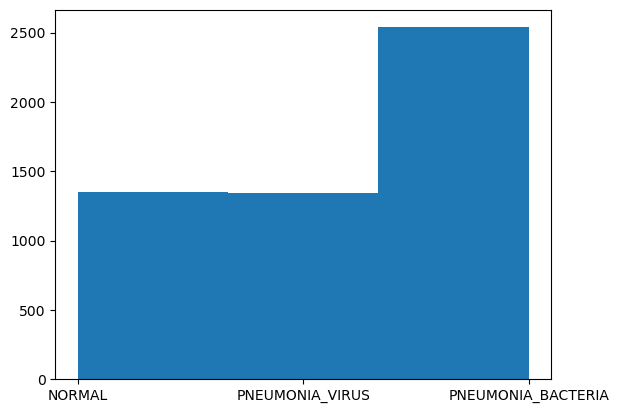

In [6]:
plt.hist(np_labels, len(set(np_labels)))
plt.show()

### Image preprocessing

In [7]:
img_size = (256, 256)

# Preprocessing of images
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(img_size),
                                transforms.RandomApply(torch.nn.ModuleList([
                                    transforms.RandomRotation(degrees=25),
                                    transforms.RandomCrop((224, 224))]), p=0.5),
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

transform_test = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

# The data sets (training and test) are extracted using the torchvision.datasets library.
train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_dir, transform=transform_test)


# The training set is divided into training data and validation data.
train_set, validation_set = random_split(train_dataset, 
                                                 (int(len(train_dataset) * 0.8)+1,
                                                 int(len(train_dataset) * 0.2)))

# The dataset is wrapped in an iterable for better access to samples in the training set.
batch_size = 64
train_dataloader = DataLoader( train_set, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader( validation_set, batch_size=batch_size, shuffle=True )
test_dataloader = DataLoader( test_dataset, batch_size=batch_size)

### Definition of the CNN architecture

Application of weights to the loss function to prevent biases in the model:

In [8]:
normal, bacteria, virus, total = visualize.count_labels(labels)

# class weights inversely proportional to frequency
class_weights = 1.0 / torch.tensor([normal, virus, bacteria], dtype=torch.float)

# Normalize weights to sum up to 1
class_weights = class_weights / class_weights.sum()

# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

#### CNN Architecture

In [9]:
# Model instance
model = cnn.CNN_NeuralNetwork().to(device)
model

CNN_NeuralNetwork(
  (conv2d_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=131072, out_features=128, bias=True)
    (1): Re

### Hyperparameters

For training, the samples have been processed in batches of 64, using a learning rate of 0.001. The dataset will be iterated over a total of 60 times unless it stops prematurely upon observing that the model does not improve after a given number of epochs.

In [10]:
learning_rate = 0.001  # 1e-3
epochs = 60

In [11]:
# Initialize the loss function
weight=class_weights
weight = weight.to(device)

train_criterion = nn.CrossEntropyLoss(weight)
test_criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.1, verbose=True)

### Train Loop

In [12]:
hist = cnn.train_model(model, train_dataloader, valid_dataloader, train_criterion, optimizer, scheduler, epochs)

Epoch 1 / 60 
-------------------------------
loss: 1.136241  [    0/ 4186]
loss: 0.917358  [ 2048/ 4186]
loss: 0.756711  [ 4096/ 4186]
Test Error: 
 Accuracy: 55.7%, Avg loss: 0.859831 

Epoch 2 / 60 
-------------------------------
loss: 0.711873  [    0/ 4186]
loss: 0.668334  [ 2048/ 4186]
loss: 0.689231  [ 4096/ 4186]
Test Error: 
 Accuracy: 69.6%, Avg loss: 0.533618 

Epoch 3 / 60 
-------------------------------
loss: 0.577437  [    0/ 4186]
loss: 0.577780  [ 2048/ 4186]
loss: 0.664673  [ 4096/ 4186]
Test Error: 
 Accuracy: 65.6%, Avg loss: 0.656018 

Epoch 4 / 60 
-------------------------------
loss: 0.717834  [    0/ 4186]
loss: 0.588618  [ 2048/ 4186]
loss: 0.729159  [ 4096/ 4186]
Test Error: 
 Accuracy: 69.7%, Avg loss: 0.552922 

Epoch 5 / 60 
-------------------------------
loss: 0.710854  [    0/ 4186]
loss: 0.593540  [ 2048/ 4186]
loss: 0.397983  [ 4096/ 4186]
Test Error: 
 Accuracy: 71.6%, Avg loss: 0.479924 

Epoch 6 / 60 
-------------------------------
loss: 0.531377

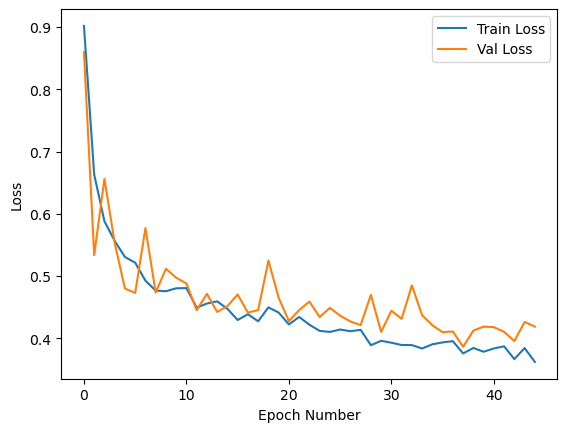

In [13]:
visualize.plot_loss_history(hist)

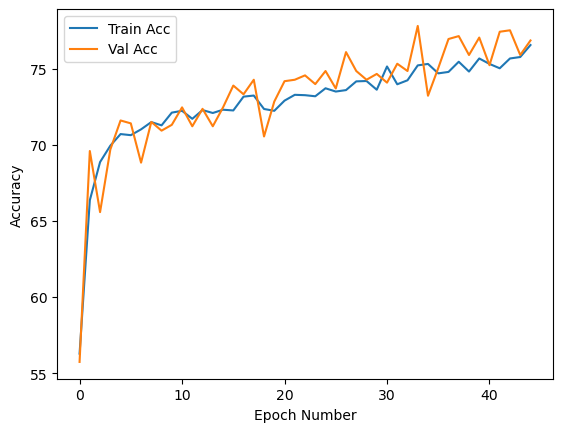

In [14]:
visualize.plot_accuracy_history(hist)

## Testing

Reading the stored model and performing the tests.

In [15]:
checkpoint = torch.load('../models/model_checkpoint.pth.tar')

In [16]:
print(checkpoint['epoch'])
print(checkpoint['accuracy'])

34
77.82026768642447


In [17]:
# Loading the model
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [18]:
# Test
accuracy, test_loss, true_labels, pred_labels = cnn.test_model(test_dataloader, model, test_criterion)

Test evaluation:
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.556740 

Done!


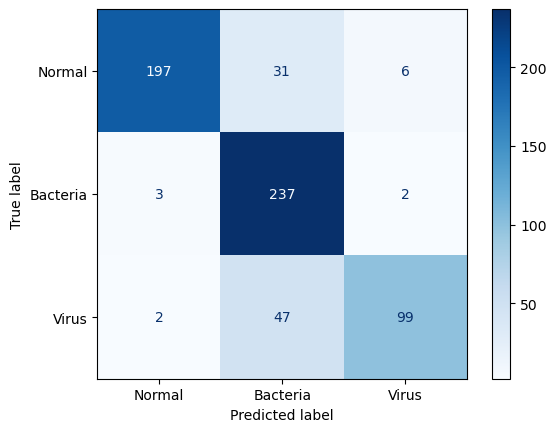

In [19]:
cm = confusion_matrix(true_labels, pred_labels)

classes=['Normal', 'Bacteria', 'Virus']
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cmDisplay.plot(cmap="Blues")
plt.show()

In [20]:
print(classification_report(true_labels, pred_labels, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.98      0.84      0.90       234
    Bacteria       0.75      0.98      0.85       242
       Virus       0.93      0.67      0.78       148

    accuracy                           0.85       624
   macro avg       0.88      0.83      0.84       624
weighted avg       0.88      0.85      0.85       624



## Image classifier

Random images are chosen to visually verify some results of the model.

In [21]:
im_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

image: NORMAL-3464500-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.9750 | Bacteria: 0.0152 | Virus: 0.0098


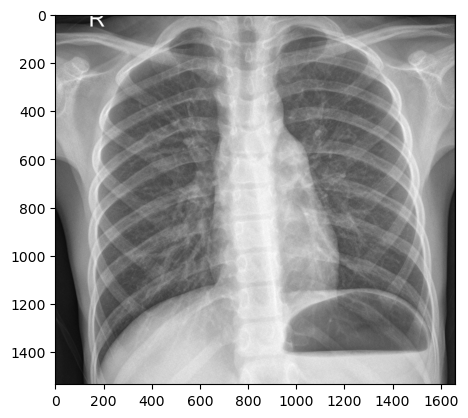

In [22]:
# Check a random sample
classes = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

visualize.classify_random_image(model, im_transform, '../../kaggle/pneumoniaDataset/chest_xray/test/', classes, device)

image: NORMAL-5200363-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 1.0000 | Bacteria: 0.0000 | Virus: 0.0000


image: NORMAL-3267425-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.8486 | Bacteria: 0.0856 | Virus: 0.0658


image: VIRUS-5927483-0001.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0014 | Bacteria: 0.3953 | Virus: 0.6033


image: BACTERIA-9913238-0003.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.0002 | Bacteria: 0.7580 | Virus: 0.2418


image: VIRUS-258000-0001.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0084 | Bacteria: 0.4560 | Virus: 0.5356


image: BACTERIA-4269599-0009.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.0002 | Bacteria: 0.7707 | Virus: 0.2291


image: VIRUS-9584831-0001.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0726 | Bacteria: 0.4398 | Virus: 0.4875


image: NORMAL-667173-0001.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0069 | Bacteria: 0.4277 | Virus: 0.5654


image: VIRUS-8427429-0001.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.002

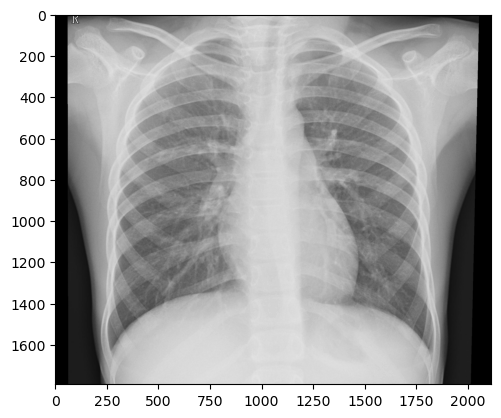

In [23]:
# Check random samples
for i in range(10):
    visualize.classify_random_image(model, im_transform, '../../kaggle/pneumoniaDataset/chest_xray/test/', classes, device)
    print("\n")

In [24]:
torch.cuda.empty_cache()